# Notebook 4: Rainfall-Runoff Modelling

## Introduction

In this notebook, we look at several ways of estimating a rainfall-runoff response hydrograph given that information availability is location-specific.

![Example Hydrograph with component flow contributions](img/hydrograph_example.png)  
(source: [Margulis 2020](https://margulis-group.github.io/textbook/))

First, we'll use the rational method to approximate peak flow based on empirical data.  We'll look at two more complex Soil Conservation Service (SCS) models, the Unit Hydrograph (SCS-UH) and Curve Number (SCS-CN) models to do the same.  We'll calculate the hydrograph response using the CN method, where the basin properties like slope and roughness are assumed to be homogeneous across the basin.  The basin parts in this case are treated as a single unit, often referred to as a "lumped" model.

Finally, we'll use an open-source geospatial library to make a simple distributed model of the basin from digital elevation data (DEM).  We'll calculate the flow direction and flow accumulation in order to delineate a basin and define the stream network, and use this to construct an hydrograph from a precipitation event.

In all cases, we'll relate the resulting flow to a practical problem involving water level in a hypothetical channel situated at the basin outlet.  The purpose is to get a feel for the range of outcomes (the peak flow of the rainfall-runoff response hydrograph) under uncertain input variables.

In [1]:
# import required packages
import os
import pandas as pd
import numpy as np
# import math

# advanced statistics library
# from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.colors as colors

working_directory = os.getcwd()
print(working_directory)

ModuleNotFoundError: No module named 'pandas'

## Find & Import Precipitation Data

We can use the application from the [Pacific Climate Impacts Consortium](https://data.pacificclimate.org/portal/pcds/map/) (PCIS) to retrieve climate observations in the Whistler area. For this exercise, we will use historical climate data from the Meteorological Service of Canada (MSC) station at Whistler, BC.  Using the *Observation Frequency* filter provided, there appear to be a few climate stations with hourly precipitation data:  

![Location of Environment Canada climate stations at Whistler with hourly data.](img/pcds_hourly_stn.png)

We'll look at one (*ID 1048899: Whistler (2014-2022)*) as an example, but we'll look at another as well because the PCIS web application suggests this station has hourly data but in fact it doesn't, nor do any of the others *except one* (925 - green triangle circled in red).  **You are always responsible for your own data validation.**  In the 

PCIS database has hourly data available at only one location in the Whistler area, and it's from the Ministry of Forests, Lands, and Resource Operations Wildfire Management Branch (FLNRO-WMB) for a brief period in 2005 (ID 925 ZZ REMSATWX1).  

In [2]:
# import precipitation data
daily_df = pd.read_csv('../../notebook_data/notebook_4_data/Whistler_348_climate.csv', parse_dates=True, index_col=['Date/Time'])
daily_df.dropna(subset=['Total Precip (mm)'], inplace=True)
daily_df.head()


Station Name  Year  Month  Day Data Quality  Max Temp (°C)  \
Date/Time                                                               
1976-11-22     WHISTLER  1976     11   22          NaN            5.6   
1976-11-23     WHISTLER  1976     11   23          NaN            5.0   
1976-11-24     WHISTLER  1976     11   24          NaN            5.0   
1976-11-25     WHISTLER  1976     11   25          NaN            4.4   
1976-11-26     WHISTLER  1976     11   26          NaN            2.2   

           Max Temp Flag  Min Temp (°C) Min Temp Flag  Mean Temp (°C)  ...  \
Date/Time                                                              ...   
1976-11-22           NaN            NaN             M             NaN  ...   
1976-11-23           NaN            0.6           NaN             2.8  ...   
1976-11-24           NaN            2.2           NaN             3.6  ...   
1976-11-25           NaN            0.6           NaN             2.5  ...   
1976-11-26           NaN           -6.7           NaN            -2.3  ...   

           Total Snow (cm)  Total Snow Flag Total Precip (mm)  \
Date/Time                                                       
1976-11-22             0.0              NaN               1.5   
1976-11-23             0.0              NaN              12.7   
1976-11-24             0.0              NaN               2.5   
1976-11-25             0.0              NaN               0.0   
1976-11-26             0.0              NaN               0.0   

            Total Precip Flag Snow on Grnd (cm)  Snow on Grnd Flag  \
Date/Time                                                            
1976-11-22                NaN               NaN                NaN   
1976-11-23                NaN               NaN                NaN   
1976-11-24                NaN               NaN                NaN   
1976-11-25                NaN               NaN                NaN   
1976-11-26                NaN               NaN                NaN   

           Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
Date/Time                                                    
1976-11-22                       NaN                   NaN   
1976-11-23                       NaN                   NaN   
1976-11-24                       NaN                   NaN   
1976-11-25                       NaN                   NaN   
1976-11-26                       NaN                   NaN   

           Spd of Max Gust (km/h)  Spd of Max Gust Flag  
Date/Time                                                
1976-11-22                    NaN                   NaN  
1976-11-23                    NaN                   NaN  
1976-11-24                    NaN                   NaN  
1976-11-25                    NaN                   NaN  
1976-11-26                    NaN                   NaN  

[5 rows x 27 columns]

In [3]:
# note that the ascii file uses the string 'None' for NaN 
# and we can deal with this on import.
hourly_df = pd.read_csv('../../notebook_data/notebook_4_data/925.ascii',
header=1, na_values=[' None'], infer_datetime_format=True, parse_dates=[' time'])
# note that the ascii format imports the column headers with spaces
# that need to be cleaned up
hourly_df.columns = [e.strip() for e in hourly_df.columns]
hourly_df.set_index('time', inplace=True, drop=True)
hourly_df.head()

wind_speed  temperature  wind_direction  \
time                                                           
2005-09-28 10:00:00        12.9         11.6           234.0   
2005-09-28 11:00:00        14.8         11.2           229.0   
2005-09-28 12:00:00        10.4         11.1           224.0   
2005-09-28 13:00:00        13.8         10.5           247.0   
2005-09-28 14:00:00        13.9         10.0           245.0   

                     relative_humidity  precipitation  
time                                                   
2005-09-28 10:00:00               61.0            0.0  
2005-09-28 11:00:00               68.0            0.0  
2005-09-28 12:00:00               76.0            0.2  
2005-09-28 13:00:00               79.0            0.0  
2005-09-28 14:00:00               80.0            0.2

## Plot the Data

Here we will use the Bokeh data visualization library to plot the precipitation data.   The ability to zoom in and out of different time scales provides a different perspective and helps with data exploration and review.  We don't have much data in this case, but if we did, holy crow, look out.

In [4]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar, ColumnDataSource
output_notebook()

hourly_source = ColumnDataSource(hourly_df)
daily_source = ColumnDataSource(daily_df)

p = figure(title=f'Precipitation', width=750, height=300, x_axis_type='datetime')

p.vbar(x='Date/Time', width=pd.Timedelta(days=1), top='Total Precip (mm)', 
bottom=0, source=daily_source, legend_label='Daily Precipitation', 
color='royalblue')

p.vbar(x='time', width=pd.Timedelta(hours=1), top='precipitation', 
bottom=0, source=hourly_source, legend_label='Hourly Precipitation', 
color='gold')

p.legend.location = 'top_left'
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Precipitation [mm]'
p.toolbar_location='above'
show(p)

Loading BokehJS ...

Use the zoom tool to compare the independent measurements over 28-29 September 2005.  Do the daily volumes add up?

In [5]:
hourly_df['day'] = hourly_df.index.day
hourly_tot = hourly_df.groupby('day')['precipitation'].sum()
print(hourly_tot)
daily_check = daily_df['2005-09-28':'2005-09-29']['Total Precip (mm)'].copy()
print(daily_check)

day
28    17.4
29    22.8
Name: precipitation, dtype: float64
Date/Time
2005-09-28    26.2
2005-09-29    17.1
Name: Total Precip (mm), dtype: float64


The two day total is very close, but the volumes don't line up despite these stations being in close proximity to each other (the Whistler station is the red triangle just north of the green triangle in the map above.)  

If we happen to be interested in *this particular* day, what other information might be relevant as far as energy inputs?  Take a look at the data columns:

In [6]:
daily_df.columns

Index(['Station Name', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)',
       'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)',
       'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag',
       'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)',
       'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag',
       'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)',
       'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag'],
      dtype='object')

How about daily temperature and snow on the ground?  How about data quality flags?

In [7]:
climate_check = daily_df['2005-09-28':'2005-09-29'][['Snow on Grnd (cm)', 'Mean Temp (°C)']].copy()
climate_check

Snow on Grnd (cm)  Mean Temp (°C)
Date/Time                                    
2005-09-28                0.0             7.0
2005-09-29                0.0            10.1

In [8]:
flag_check = daily_df['2005-09-28':'2005-09-29'][['Snow on Grnd Flag', 'Mean Temp Flag', 'Total Precip Flag']].copy()
flag_check

Snow on Grnd Flag Mean Temp Flag Total Precip Flag
Date/Time                                                    
2005-09-28               NaN            NaN               NaN
2005-09-29               NaN            NaN               NaN

No data flags, and no snow on the ground, so we might have a bit more confidence in this data.

### Problem Setup

Let's imagine you had a summer job in Whistler working on a project to grade and re-pave the area around Day Lot 4, including installing drainage to capture water from the parking lot and divert it to a storm water collection system instead of draining into FitzSimmons Creek.  

![Satellite Image of the Day Lot 4 area in Whistler](img/lot4_diagram1.png)

It's summer and the project is scheduled to be completed by fall.  For the sake of this exercise, assume the slope of the parking lot area describes a catchment of roughly **1 $km^2$** and empties through a temporary channel into a catch basin to be treated before flowing into FitzSimmons Creek.  Unfortunately, beyond the outlet (red dot in the diagram above), the channel has to cross the pedestrian trail that follows the river left bank.  Assume the channel is rectangular in shape, and is 2m wide by 0.25m deep with a hydraulic grade slope of 0.5%.  

* **Channel width (w)**: $2m$
* **Channel Depth (h)**: $0.25m$
* **Hydraulic Grade Line Slope (S)**: 0.005 (0.5%)
* **Roughness (n)**: 0.017 (rough asphalt)

>**Note:** Given the drainage area is only $1 km^2$, do you have a sense of what duration of rainfall is appropriate for estimating the peak of the runoff response hydrograph?  *i.e. 1h, 6h, 24h, 48h?* 

## Hydrograph Development

It is rare to find long-term records at a high frequency of measurement, so **we do the best we can with the information available**.  Below, we'll look at a few ways of constructing a hydrograph.  We want to construct a hydrograph because if we can accurately predict its peak (or more generally its shape), we can design hydraulic structures and other water management systems.  We'll start with a very basic estimate that has minimal information requirements, and move to more complex and information-intensive methods.  

In the problem setup we asked *"will the outlet channel be big enough"*.  Water resources problems are often expressed in terms of risk, and typically for this kind of analysis we communicate risk in terms of annual exceedance probability (AEP).  In other words, what is the probability that the flow in the channel will exceed its capacity in a given year?  **These kinds of problems do not have a right answer, they are open-ended and subjective&mdash;meaning any answer involves some amount of (engineering) judgment.**  The topic of risk will be discussed further in Notebook 5.  For now, we'll just focus on a few ways of estimating a runoff hydrograph from precipitation data.


### Rational Method

Recall that the peak runoff for a small basin can be estimated by [the following](https://www.tad.usace.army.mil/Portals/53/docs/TAA/AEDDesignRequirements/AED%20Design%20Requirements-%20Hydrology%20Studies_Feb-11.pdf) from the US Army Corps of Engineers (USACE):

$$Q = k\cdot C\cdot I \cdot a$$

Where:

* **Q**: is the peak discharge of the event [$m^3/s$]
* **k**: 0.278 [-]
* **C**: runoff coefficient [-]
* **I**: rainfall intensity [mm/hr]
* **a**: drainage area [$km^2$]

We have already estimated drainage area, and there are just two additional pieces of information we need to estimate the peak runoff for our basin.  The runoff coefficient "C" can be found in a table of empirical values in the USACE link above, and the rainfall intensity can be estimated from [Intensity-Duration-Frequency](https://climate.weather.gc.ca/prods_servs/engineering_e.html) curve data developed by Environment Canada.  More [information on IDF Curve usage can be found here](https://climatedata.ca/resource/best-practices-for-using-idf-curves/).  We can find IDF curves for specific locations using the [web application at climatedata.ca](https://climatedata.ca/download/#idf-download).  The IDF curve for Whistler is below:

![IDF Curve for Whistler, BC.](img/IDF.png)



We don't really know the appropriate duration (x-axis) yet for our basin, but we can select a few and run calculations to see how sensitive this model is to the duration.  The five diagonal lines represent different return periods (2, 5, 10, 20, 50, 100 years).  The return period is the inverse of the AEP, and again it represents the probability of occurrence **in any given year**, and it does not suggest an event of any magnitude will occur once in that return period.  

Below we'll express the values that we're not too sure about as plausible ranges, and test their effect on the result.

In [9]:
def rational_method_peak_flow(C, I, a):
    """Calculate peak flow (m^3/s) using the rational method.

    Args:
        C (float): runoff coefficient
        I (float): rainfall intensity [mm/hr]
        a (float): drainage area [km^2]
    """
    return 0.278 * C * I * a

In [10]:
# for each return period, we'll read the minimum and maximum intensity
# and use these to see the range of outcomes
IDF_dict = {
    5: (22, 45), # the 2 and 100 year intensities are 22mm, 45mm (5 min)
    15: (14, 28),
    60: (7, 15),
    1440: (2, 4) # 1440 minutes is 24 hours
}        

In [11]:
# here we'll define an array of three runoff coefficient values 
# to get a sense of the range of possible conditions
# minimum, maximum, and expected value
C_values = [0.5, 0.7, 0.9]

# calculate the range of flow estimates for each C and each return period
# and create a plot for each runoff coefficient
figs = []
rational_results = {}
colors=['green', 'orange', 'red']
for k, (i_min, i_max) in IDF_dict.items(): 
    i = 0
    p = figure(title=f'Duration={k}min', width=600, height=400) 
    for c in C_values:
        Q_min = rational_method_peak_flow(c, i_min, 1)
        Q_max = rational_method_peak_flow(c, i_max, 1)
        x = [2, 100]
        y = [Q_min, Q_max]
        p.line(x, y, legend_label=f'C={c}', color=colors[i])
        p.yaxis.axis_label = 'Flow [m^3/s]'
        p.xaxis.axis_label = 'Return Period'
        p.legend.location = 'top_left'
        i += 1

    figs.append(p)

In [12]:
from bokeh.layouts import gridplot
layout = gridplot(figs, ncols=2, width=350, height=300)
show(layout)

>**Pause and reflect**: From the plots above, is it more critical to get the correct duration, to select an appropriate return period, or to get an accurate estimate of the runoff coefficient?  In other words, how sensitive is the model to the different input parameters?  

### SCS Unit Hydrograph Model

The unit hydrograph diagram below describes an idealized basin response to precipitation, and it is used in physically-based models to estimate the peak of the hydrograph response.  The shape of the hydrograph has many influences, and it is controlled by complex interactions between the atmosphere, the surface (i.e. vegetation, roughness, slope), and the subsurface (i.e. antecedent soil moisture, permeability, porosity).  Generally these values are carefully calibrated by concurrent runoff and precipitation measurement covering the broadest possible range of conditions.  

The information requirement is intensive for the SCS-UH method compared to the rational method, and it is highly dependent upon a specific location and highly variable in time.  This information may be available in some applications like urban hydrology where detailed survey information, surfaces, slopes, etc. can be acquired.  In such a case the [Soil Conservation Service (SCS) Unit Hydrograph model](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/surface-runoff/scs-unit-hydrograph-model) may be useful. 


$$U_P = C \frac{A}{T_p}$$

* **$U_P$**: peak flow
* **$C$**: conversion constant
* **$A$**: basin area
* **$T_p$**: time of peak

![Diagram describing the relationship between lag time, time of concentration, and ](img/toc_diagram.png) 

(source: [USDA National Engineering Handbook: Chapter 15 - Time of Concentration](https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=27002.wba))



A more intuitive description of time of concentration $t_c$ is the time it takes for flow to travel from the furthest point in the watershed to the outlet.  The $t_c$ approximate the furthest flow path in our basin and break it up into components:

$$t_c = t_{sheet} + t_{shallow} + t_{channel}$$

The above three flow components are just a 3-parameter model of the average velocity of flow over the longest flow path.  **In reality, we should use only as many parameters as we can defend with evidence.**  Again, these estimates should in reality be based on careful field observation.  For our simple example problem, we won't elaborate further than showing the equations for estimating times.

$$t_{sheet} = \frac{0.007(N \cdot L)^{0.8}}{P_2^{0.5}S^{0.4}}$$

$$t_{shallow} = \frac{L}{V_{shallow}} = \frac{250}{20.3282 \sqrt{S}} \quad (\text{unpaved surface})$$

Where:

* **$N$**: overland roughness coefficient [-]
* **$L$**: length of flow path [m]
* **$P$**: design (excess) rainfall depth [mm]
* **$S$**: slope of hydraulic grade line (land slope) [m/m]
* **$V$**: average (shallow flow) velocity [m/s]


In [13]:
def calculate_t_sheet(n, L, P, s):
    return 0.007 * (n * L)**0.8 / ((P**0.5) * s**0.4 )


t_t = 0.2 # 0.2 hour channel flow
n = 0.0011
s = 0.005
L = 300 # 100m is roughly 300 ft.
P_mm = 2 * 24
P_in = 2 # 48mm is roughly 2 inches

t_sheet = calculate_t_sheet(n, L, P_in, s)
print(f'Sheet flow time is {t_sheet:.3f}hr + {t_t:.2f} shallow flow = {t_sheet+t_t:.3f} hours.')

Sheet flow time is 0.017hr + 0.20 shallow flow = 0.217 hours.


The time of concentration is about a third of an hour for our small basin.  We can use this to approximate a runoff hydrograph.

### SCS Curve Number (CN) Method

The [SCS Curve Number Method](https://www.nrcs.usda.gov/Internet/FSE_DOCUMENTS/stelprdb1044171.pdf) requires less information but has a few more parameters compared to the rational method to approximate surface losses by classifying the land cover (see Chapter 2 in the linked pdf):

$$Q = \frac{(P-I_a)^2}{(P-I_a) + S} = \frac{(P-0.2S)^2}{(P+0.8S)}$$

* **$P$**: rainfall
* **$S$**: potential retention after runoff begins 
* **$I_a$**: initial losses before runoff begins ($I_a \approx 0.2S$)

$$S = \frac{1000}{\text{CN}} - 10$$

* **CN**: curve number (from below)

![Curve number for peak runoff estimation](img/cn_figure.png)

From Table 2-2a in the CN method document, curve numbers for gravel roads range from 76 to 91 for hydrologic soil groups A, B, C, and D.  

We also need to estimate the time of concentration, which is discussed in Chapter 3 of the SCS CN method document linked above.  From Figure 3-1, the average flow velocity for shallow concentrated flow over unpaved surface (gravel) is 1.2 ft/s (0.37 m/s).  For a 250m channel length this translates to 0.2 hours.


A model for sheet flow time is as follows:

$$T_t = \frac{0.007(nL)^{0.8}}{P_2^{0.5}s^{0.4}}$$


In [14]:
def CN_method_Q(P, CN):
    S = 1000.0 / CN - 10
    return ((P - 0.2 * S)**2) / (P + 0.8 * S)

In [16]:
CNs = [76, 85, 89, 91]

CN_Qs = []

for cn in CNs:
    CN_Qs.append(CN_method_Q(, cn))

SyntaxError: invalid syntax (<ipython-input-16-49e3012ab04a>, line 6)

As with our rational method estimate, let's see the effect of uncertainty in a few of our parameters.  For this example, let's test the precipitation loss from infiltration, which dictates the excess precipitation volume, the lag time, and the time of concentration.  We'll plot precipitation a range of (constant) loss rates against the hourly data we imported above to better illustrate the assumptions.

In [17]:
precip_losses = [1, 2, 4] # mm/hr

p = figure(title=f'Precipitation vs. Losses', width=750, height=300, x_axis_type='datetime')

p.vbar(x='time', width=pd.Timedelta(hours=1), top='precipitation', 
bottom=0, source=hourly_source, legend_label='Hourly Precipitation', 
color='royalblue', fill_alpha=0.5)

t_loss = [hourly_df.index[0], hourly_df.index[-1]]

colors = ['blue', 'green', 'orange', 'red']
i = 0
for l in precip_losses:
    p.line(
        t_loss, [l, l], 
        line_dash='dashed', legend_label=f'{l}mm/hr loss',
        color=colors[i]
    )
    i += 1

p.legend.location = 'top_left'
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Precipitation [mm]'
p.toolbar_location='above'
show(p)

From the above plot, the excess precipitation is the blue area above each of the loss function lines.  Let's plot the three different excess precipitation series.

In [18]:
for l in precip_losses:
    hourly_df[f'excess_{l}'] = (hourly_df['precipitation'] - l).clip(0, None)


hourly_df['day'] = hourly_df.index.day

excess_rainfall = hourly_df[[f'excess_{l}' for l in precip_losses] + ['day']].groupby('day').sum()
excess_rainfall

excess_1  excess_2  excess_4
day                              
28        8.0       1.8       0.0
29       10.4       4.6       1.4

In [19]:
hourly_source = ColumnDataSource(hourly_df)
p = figure(title=f'Excess Precipitation', width=650, height=250, x_axis_type='datetime')

i = 0
for l in precip_losses:
    p.vbar(x='time', width=pd.Timedelta(minutes=20), top=f'excess_{l}', 
    bottom=0, source=hourly_source, legend_label=f'{l}mm loss excess', 
    color=colors[i], fill_alpha=0.5)
    # shift the index by 20min to make bars line up next to each other
    hourly_df.index += pd.Timedelta(minutes=20)
    hourly_source = ColumnDataSource(hourly_df)
    i += 1

# make sure to reset the index!!
hourly_df.index -= pd.Timedelta(hours=1)
p.legend.location = 'top_left'
show(p)

#### Time of concentration

In [20]:
def sheet_flow_time(P, S, N, L):
    return 0.007 * (N * L)**(0.8) / (P**(0.5) * S**(0.4))

def shallow_flow_time(S, L):
    return L / (20.3282 * np.sqrt(S))

def calculate_time_of_concentration(P, S, N, L):
    t_sheet = sheet_flow_time(P, S, N, L)
    t_shallow = shallow_flow_time(S, L)
    return t_sheet + t_shallow

def calculate_SCS_peak_flow(C, A, P, S, N, L, t_excess_precip):
    a = A * 1000 * 1000 # convert km^2 to m^2

    # convert mm per (n-hours duration) to mm/hr
    p_hourly = P / t_excess_precip
    p_m = p_hourly / 1000 # convert mm/hr to m/hr
    t_c = calculate_time_of_concentration(p_m, S, N, L)
    t_lag = 0.6 * t_c # in hours
    del_t = t_excess_precip 
    T_p = t_lag + del_t / 2 # in hours
    U_p = C * a / T_p
    # convert peak flow to 
    return 
    

In [21]:
# approximate the range of excess rainfall we see above
P_excess = [2, 7, 20]  

# approximate a range of excess precip durations [hours] 
# from the above plot corresponding to the three excess precip volumes
excess_precip_durations = [1, 2, 7]
S = 0.005 # 0.5%
N = 0.011
L = 250
C = 2.08 # conversion constant
A = 1 # drainage area [km^2]

tcs = []
i = 0
for p in P_excess:
    U_p = calculate_SCS_peak_flow(C, A, p, S, N, L, excess_precip_durations[i])
    tcs.append(U_p)
    i += 1

In [22]:
tcs

[None, None, None]

## Rainfall-Runoff Response by the Rational Method

Below, we find a single precipitation event to use as an example for estimating a runoff hydrograph.  Below we plot a two week period where 

## Convert Volume to volmeteric flow units

Runoff is typically measured in $\frac{m^3}{s}$, so convert $\frac{mm}{day}$ precipitation to $\frac{m^3}{s}$ runoff.

$$1 \frac{mm}{day} \times \frac{1 m}{1000 mm} \times \frac{1 day}{24 h} \times \frac{1 h}{ 3600 s} \times 1 km^2 \times \frac{1000 m \times 1000 m}{1 km^2}= \frac{1}{86.4} \frac{m^3}{s}$$

In [23]:
# convert to runoff volume
drainage_area = 1 # km^2

# runoff is typically measured in m^3/s, 
# (cms for short -- cubic metres per second), 
# so express the runoff in cms
event_df = daily_df['':''].copy()
event_df['runoff_cms'] = event_df['Total Rain (mm)'] / 86.4

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [] of type str

If the channel outlet has a rectangular shape of width 2m, how tall should our boots be?  Assume a 0.5% slope, and find a reasonable assumption for the roughness of asphalt.

Recall the Manning equation:

$$Q = \frac{1}{n} A R^{2/3} S^{1/2}$$

Where:
* **n** is the manning roughness
* **A** is cross sectional area of the flow
* **R** hydraulic radius (area / wetted perimeter)
* **S** is the channel slope

In [24]:
# specify our given information
w_channel = 2 # m
S = 0.005 # channel slope
n_factor = 0.017  # rough asphalt

def calc_Q(d, w, S, n):
    """
    Calculate flow from the Manning equation.
    """
    A = d * w # flow area as (depth x width)
    wp = w + 2 * d  # wetted perimeter
    R = A / wp # hydraulic radius (area / wetted perimeter)
    return (1/n) * A * R**(2/3) * S**(1/2)

def solve_depth(w, n_factor, Q, S):
    """
    Given a flow, a roughness factor, a channel slope, and a channel width, 
    calculate flow depth. 
    """
    e = 1 / 100  # solve within 1%
    d = 0
    Q_est = 0
    n = 0
    while (abs(Q_est - Q) > e) & (n < 1000):
        Q_est = calc_Q(d, w, S, n_factor)
#         print(Q, Q_est, abs(Q_est - Q))
        d += 0.001
        n += 1
#     print('solved in {} iterations'.format(n))
    return d 
    

In [25]:
# For each timestep, we want to solve for the depth of water at our outlet
event_df['flow_depth_m'] = event_df['runoff_cms'].apply(lambda x: solve_depth(w_channel, n_factor, x, S))

NameError: name 'event_df' is not defined

In [26]:
plt.plot(daily_df.index, daily_df['flow_depth_m'])
plt.ylabel('Flow depth [m]')

KeyError: 'flow_depth_m'

>**Not only are our feet wet, but if we happen to be there the peak it's potentially dangerous.  As little as 10-15cm of water quickly enough can sweep you off your feet.**

![Recalculating Life](img/recalculating.png)

## Distributed Model from Spatial Data

As discussed in class, precipitation takes time to flow to the basin outlet, and there are complex interactions with the atmosphere, vegetation, the ground surface, and the subsurface that make predicting the basin response to precipitation very difficult to model accurately.  Now we'll use DEM data to delineate a basin and make a simple distributed model to create a unit hydrograph.

### Import the DEM and plot the data

Here we'll use the [Pysheds](https://github.com/mdbartos/pysheds) library to process the DEM.

In [144]:
from pysheds.grid import Grid

data_path = '../../notebook_data/notebook_4_data/'
dem_file = 'Whistler_DEM.tif'
dem_path = data_path + dem_file

grid = Grid.from_raster(dem_path)
dem = grid.read_raster(dem_path)

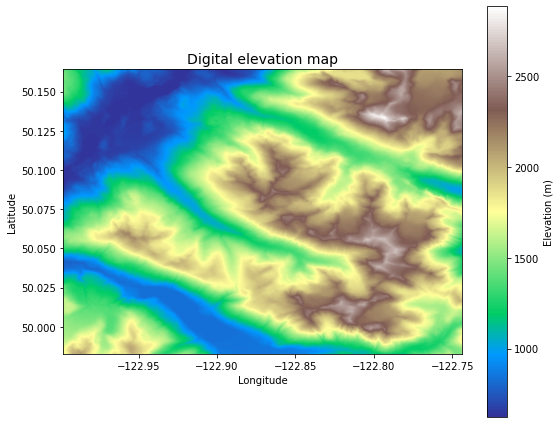

In [145]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=2)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

### Fill Pits and Resolve flats in DEM

The sampling of surface elevations from a DEM often contain depressions and flat regions that must be filled before the raster can be processed and flow paths will resolve. 

In [146]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

### Derive flow directions from DEM

Each cell of a DEM raster is assigned a flow direction calculated by determining the slope at that pixel/cell.  The slope is determined by comparing elevations with the 8 surrounding/connected pixels.  Directions are assigned one of eight values corresponding to 8-bit integers ($2^1, 2^2, 2^3, \dots 2^7$)


| | | |
|---|---|---|
| 32 | 64 | 128 |
| 16 | C | 1 |
| 8 | 4 | 2 |

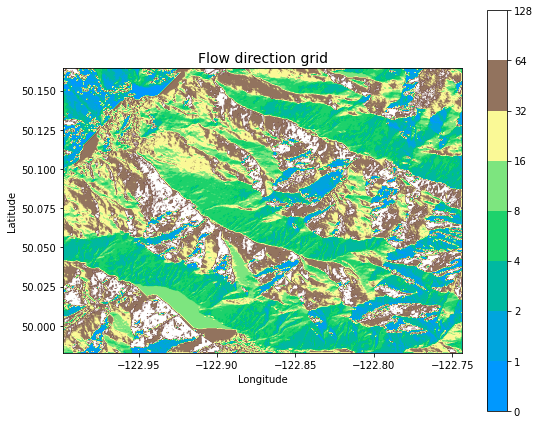

In [147]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

# we have to normalize the colors to provide contrast
cNorm  = colors.PowerNorm(gamma=0.5)
plt.imshow(fdir, extent=grid.extent, norm=cNorm,
cmap='terrain', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

### Get flow accumulation

Recall from the exercise in class how we derived flow accumulation from the flow direction.  Each cell has a direction associated with it.  Flow accumulation in this case is expressed as the number of upstream cells.  

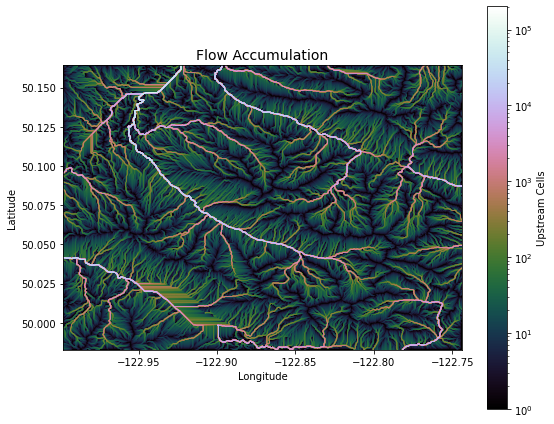

In [148]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

### Delineate a Catchment

Below we will delineate a basin corresponding to the hydrometric station located on Fitzsimmons Creek.  Water Survey of Canada have [recently published](https://open.canada.ca/data/en/dataset/0c121878-ac23-46f5-95df-eb9960753375) basin polygons for nearly 7000 stations across Canada.  In addition, pour points are also provided as shape files.  A limitation of Whiteboxtools is we need to specify the pour point as a file (.shp or .geojson) and we can't just provide coordinates.  The pour point is the outlet of the basin.  If we have high resolutoin data and imperfect coordinates of a pour point, we will not get the correct pixel corresponding to the outlet. 


In [149]:
# Delineate a catchment
# ---------------------
# Specify pour point (WSC Station at Fitzsimmons Creek in Whistler: 08MG026)
x, y = -122.9488, 50.12025

# specify a threshold for flow accumulation in cells
# for this raster, 500 cells is roughly 0.5 km^2
accumulation_threshold = 500

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

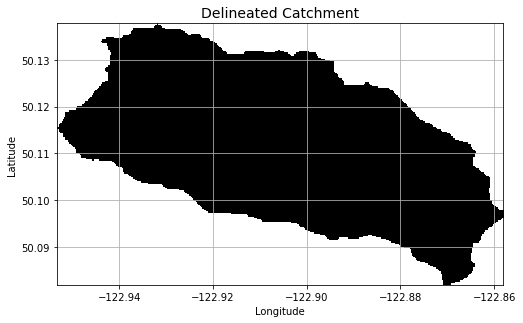

In [150]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent, zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

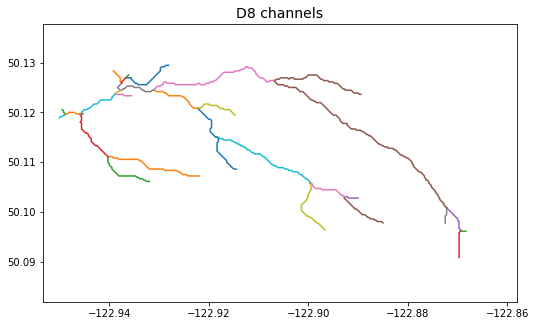

In [151]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 500, dirmap=dirmap)

fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

### Calculate distances to upstream cells

Text(0.5, 1.0, 'Flow Distance')

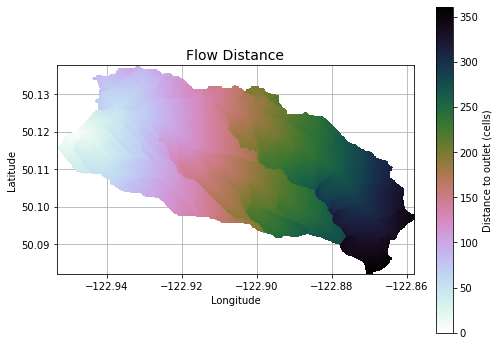

In [152]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

### Calculate weighted travel distance

Assign a travel time to each cell based on the assumption that water travels at one speed (overland flow is slower) until it accumulates into a stream network, at which point its speed increases dramatically.

In [163]:
# Compute flow accumulation
acc = grid.accumulation(fdir)

# Assume that water in channelized cells (>= 500 accumulation) 
# travels 10 times faster than hillslope cells (< 500 accumulation)
# i.e. if average channel velocity is 1m/s, hillslope is 0.1m/s = 10 cm/s
weights = acc.copy()
weights[acc >= accumulation_threshold] = 0.1
weights[(acc > 0) & (acc < accumulation_threshold)] = 1

# # Compute weighted distance to outlet
weighted_dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, weights=weights, xytype='coordinate')

Text(0.5, 1.0, 'Weighted distance to outlet')

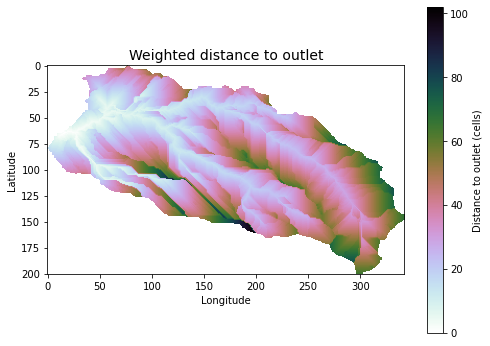

In [164]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
# plt.grid('on', zorder=0)
im = ax.imshow(weighted_dist, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Weighted distance to outlet', size=14)

## Develop Rainfall-Runoff Model

Now that we have weighted flow distances for each cell in the delineated catchment, we can apply precipitation to each 'cell' in order to reconstruct a flow hydrograph.  

First, we must figure out the cell dimensions.  From the [USGS Hydrosheds information](https://hydrosheds.cr.usgs.gov/datadownload.php), we know the resolution is 15 (degree) seconds.  Because the earth is not a perfect sphere, [coordinate projection systems](https://epsg.io/) (CRS) are used to approximate the surface of the earth so that spatial distances can be more accurately represented.

Note that our 'weighted distance' has just provided a relative difference between the flow accumulation cells and non-flow-accumulation cells.  We still must convert these values to some time-dependent form.

For this exercise, we will assume the average velocity of water is 1 m/s value for the flow accumulation cells, and 0.01 m/s for hillslope cells.  Let's calculate the unweighted and weighted time of concentration (time to travel from furthest cell to the outlet).

The DEM is from the USGS 3DEP program and is roughly 30x30m resolution (each pixel represents an area of roughly 30m by 30m).  We have reduced the (distance) weight of channel cells, so the distance is proportional to our estimate of hillslope velocity, and we can convert the distance to time by dividing the weighted distance by 1 m/s. 

In [185]:
# get the raster pixel resolution
resolution = (30, 30)

# cells can be grouped by their weighted distance to the outlet to simplify 
# the process of calculating the contribution of each cell to flow at the outlet
dist_df = pd.DataFrame()
dist_df['weighted_dist'] = weighted_dist.flatten()

# trim the distance dataframe to include only the cells in the catchment,
# and round the travel time to the nearest distance unit (number of cells)
dist_df = dist_df[np.isfinite(dist_df['weighted_dist'])].round(0)


In [187]:
# get the number of cells of each distance
grouped_dists = pd.DataFrame(dist_df.groupby('weighted_dist').size())
grouped_dists.columns = ['num_cells']


In [188]:
# create unit hydrographs for each timestep
runoff_df = pd.DataFrame(np.zeros(len(hourly_df)))
runoff_df.columns = ['Total Precip (mm)']
runoff_df.index = hourly_df.index.copy()
end_date = pd.to_datetime(runoff_df.index.values[-1]) + pd.DateOffset(hours=1)
max_distance = max(grouped_dists.index)




The maximum adjusted flow path is 102.0 cells, corresponding to a maximum flow travel time of 9.0 hours.


In [189]:
def calculate_flow_time(distance, v):
    # convert flow path length (in cells)
    # to a travel time
    return np.ceil(distance * resolution[0] / v / 3600)


In [192]:
# time of concentration
flow_velocity = 0.1 # m/s
max_flow_time = calculate_flow_time(max_distance, flow_velocity)
print(f'The maximum adjusted flow path is {max_distance} cells, corresponding to a maximum flow travel time of {max_flow_time} hours.')

extended_df = pd.DataFrame()
extended_df['Total Precip (mm)'] = [0 for e in range(int(max_flow_time) + 1)]
extended_df.index = pd.date_range(end_date, periods=max_flow_time + 1, freq='1H')
# append the extra time to the runoff dataframe
runoff_df = runoff_df.append(extended_df)
runoff_df['Runoff (cms)'] = 0

The maximum adjusted flow path is 102.0 cells, corresponding to a maximum flow travel time of 9.0 hours.


The cell below is a big computation and may take some time.  What is happening below is for each hour of precipitation, we calculate the time offset for the flow to get from each cell to the outlet.  Each cell does not take the same amount of time for flow to get to the outlet, so we add each cell's runoff at the future time corresponding to the cell's travel time.  

We make it slightly more efficient by grouping cells of equal distance.

In [197]:
runoff_coefficient = 0.3

for ind, row in hourly_df.iterrows():
    this_hyd = hourly_df[['precipitation']].copy()
    hydrograph = pd.DataFrame()
    for weight_dist, num_cells in grouped_dists.iterrows():
        weighted_time = calculate_flow_time(weight_dist, flow_velocity)
        outlet_time = ind + pd.Timedelta(hours=weight_dist)
        # round the travel time to nearest hour 
        # to align with hourly streamflow data
        if weight_dist < 1:
            outlet_time = ind + pd.Timedelta(hours=1)
        else:
            outlet_time = outlet_time.round('H')
            
        precip_vol = num_cells.values[0] * row['precipitation']
        runoff_vol = precip_vol * runoff_coefficient / 1000 * resolution[0]**2 
        runoff_rate = runoff_vol  / 3600  # convert to m^3/s from m^3/h    
        runoff_df.loc[outlet_time, 'Runoff (cms)'] += runoff_rate


2005-09-28 11:00:00


NameError: name 'asdf' is not defined

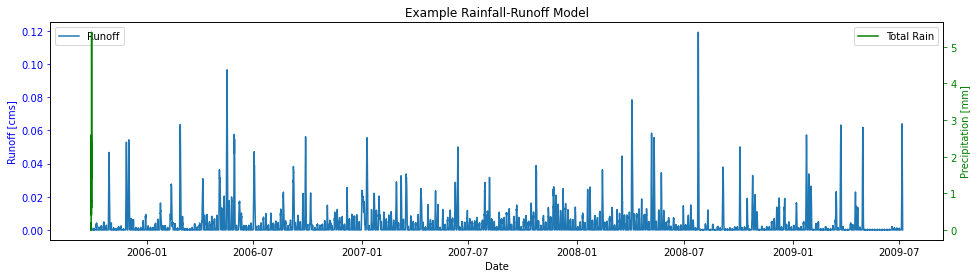

In [124]:

fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(runoff_df.index, runoff_df['Runoff (cms)'], label="Runoff")

ax.set_xlabel('Date')
ax.set_ylabel('Runoff [cms]', color='blue')
ax.set_title('Example Rainfall-Runoff Model')
ax.legend(loc='upper left')
ax.tick_params(axis='y', colors='blue')

ax1 = ax.twinx()
# plot the precipitation
ax1.plot(hourly_df.index, hourly_df['precipitation'], 
         color='green',
         label="Total Rain")
ax1.set_ylabel('Precipitation [mm]', color='green')
ax1.tick_params(axis='y', colors='green')
ax1.legend(loc='upper right')

### Determine the Peak Unit Runoff

First, estimate the drainage area.  Then, find the peak hourly flow.

In [ ]:
DA = round(grouped_dists.sum().values[0] * 0.3 * 0.3, 0)
max_UR = runoff_df['Runoff (cms)'].max() / DA * 1000
print('The drainage area is {} km^2 and the peak Unit Runoff is {} L/s/km^2'.format(DA, int(max_UR)))

Discuss the limitations of the approach.  Where do uncertainties exist?

* assumed precipitation is constant across days
* assumed constant runoff coefficient
* assumed two weights for travel time, constant across time

## Question for Reflection

For the first part where we estimated the water level at the parking lot outlet based on an assumption that there was zero infiltration, assuming all else is equal, how could we reduce the maximum water level to 5 cm?  